## Package Description

`bmdrc` is a python library for calculating **B**ench**m**ark **D**ose **R**esponse **C**urves. This tutorial will take users through the library using a dichotomous (binary response) example. `bmdrc` is broken up into five modules 

1. *Input Data Module:* Import data into the python library.

2. *Pre-Processing Module:* Combine and remove endpoints as needed.

3. *Filtering Modules:* Apply recommended filters from the EPA and statistics experts.

4. *Model Fitting Modules:* Fit recommended models from the EPA and experts. The best fit model is autoselected for you.

5. *Output Modules:* Select tables to output as csvs. View plots in a HTML report.

First, install the package from pip using: 

`pip install bmdrc`

Or from github using: 

`pip install git+https://github.com/PNNL-CompBio/bmdrc`

## Datatype Description

**Dichotomous Data**

- *BinaryClass* The `BinaryClass` object contains specific pre-processing and filtering functions that pertain to plates and wells. Each value should be a 0, 1, or NA, and *bmdrc* will caculate the response column. The following columns are needed for data in long and wide format: chemical, plate, well, concentration. The following columns are only needed for data in wide format: endpoint, value. 

- *ProportionalClass* If your data does not contain plates and wells, the `ProportionalClass` object only requires a chemical, endpoint, concentration, and response (a proportion ranging from 0 to 1). Data must be in long format. 

- *LPRClass* In the `LPRClass`, larval photomotor response data can be converted to dichotomous as described in [Thomas et al 2019](https://www.sciencedirect.com/science/article/pii/S2468111318300732). Data must be in long format and contain the following columns: chemical, plate, well, concentration, time, and value. Users must specify the time between cycles, the cooldown time between cycles, and whether to start with a light or dark cycle. If this format does not fit your data nicely, please report it to the issues tab. 

**Continuous Data**

- *ContinuousClass* The `ContinuousClass` object requires only four columns: chemical, endpoint, concentration, and response (a continuous variable with any range). All selected models support negative numbers and zeroes. NA values are automatically filtered out. Optionally, an ANOVA can be fit to determine if there's differences in concentrations, with checks to ensure an ANOVA model is appropriate for the given dataset.


In [1]:
# Load local installation of libraries
import bmdrc
import pandas as pd

## Module 1: Input Data

The first step to using the bmdrc python library is to properly format the data. Here we will use the `ContinuousClass` function, which requires a pandas DataFrame with the following columns: chemical, endpoint, concentration, and response.

In [2]:
from bmdrc.ContinuousClass import ContinuousClass

con = ContinuousClass(
    df = pd.read_table("../data/Continuous.txt"), # Input is a pandas DataFrame
    chemical = "Chemical ID", # The name of the chemical column 
    endpoint = "Endpoint", # The name of the column with endpoints
    concentration = "Concentration_uM", # The name of the concentration column
    response = "Measurement" # The name of the column with a numeric response column
)

## Module 2: Pre-Processing

Endpoints that should not be modeled can be removed at this step. 

#### Remove Endpoints

In [3]:
# Remove Endpoint 5
con.remove_endpoints(endpoint_name = "Endpoint5")
con.df[con.endpoint].unique()

array(['Endpoint1', 'Endpoint2', 'Endpoint3', 'Endpoint4', 'Endpoint6'],
      dtype=object)

## Module 3: Filtering

#### Minimum Concentration Filter

The assumption is that there should be at least 3 non-zero concentration measurements to fit a curve. 

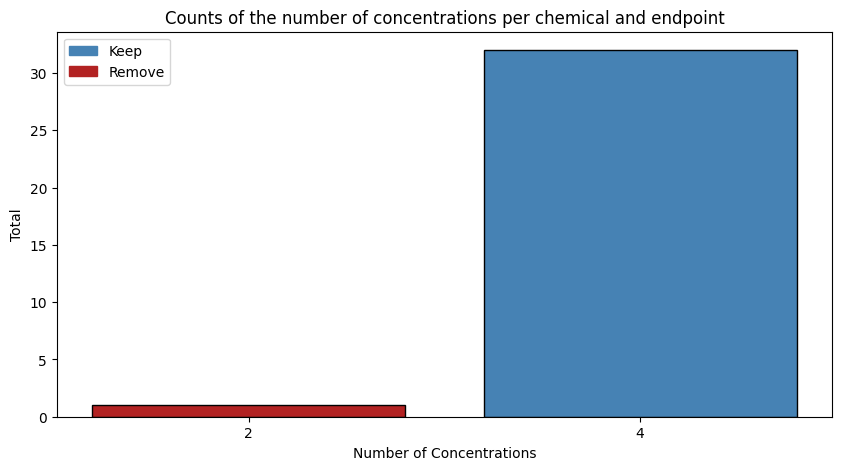

In [4]:
# Set the percentage and build the diagnostic plot, but don't actually apply the filter. 
con.filter_min_concentration(count = 3, apply = False, diagnostic_plot = True)

In [5]:
# Let's see a summary table
con.filter_min_concentration_df

,NumConc,Count,Filter
0,4,32,Keep
1,2,1,Remove


In [6]:
# Apply the filter with defaults
con.filter_min_concentration(apply = True)

### Correlation Score Filter

To fit a curve, we expect the response to increase or decrease with dose. Here, an absolute value of the EPA recommended threshold of 0.2 is used. Note that the default parameter for direction is `below` and need to be set to `between` for between the absolute threshold and -1 times the absolute threshold.

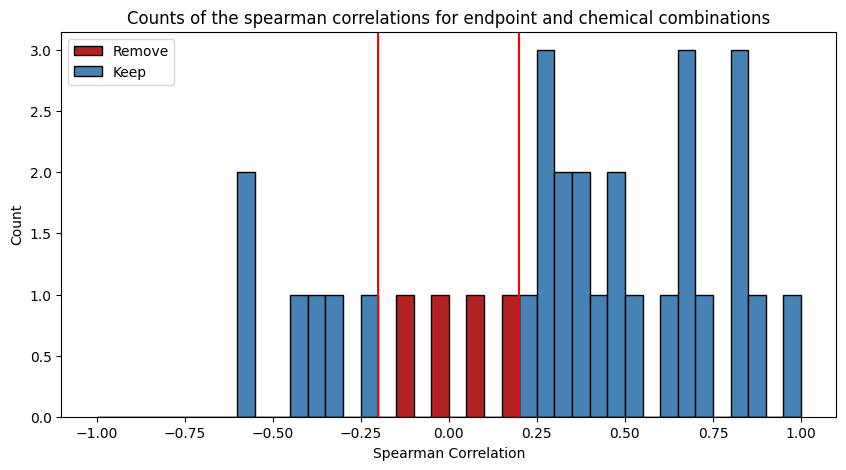

In [7]:
# View filter
con.filter_correlation_score(score = 0.2, diagnostic_plot = True, apply = False, direction = "between")
con.filter_correlation_score_plot

In [8]:
con.filter_correlation_score_df

,bmdrc.Endpoint.ID,Spearman,Filter
0,1 Endpoint3,0.300438,Keep
1,1 Endpoint4,-0.033786,Remove
2,10 Endpoint2,0.889052,Keep
3,11 Endpoint1,0.840001,Keep
4,11 Endpoint2,0.662190,Keep
5,12 Endpoint1,0.282044,Keep
6,12 Endpoint2,0.472117,Keep
7,12 Endpoint3,0.269781,Keep
8,12 Endpoint4,0.223964,Keep
9,13 Endpoint1,0.478249,Keep


In [9]:
# Apply the filter with defaults
con.filter_correlation_score(score = 0.2, apply = True, direction = "between")

## Module 4: Model Fitting

In [10]:
data = con.df[(con.df["Chemical ID"] == "12") & (con.df["Endpoint"] == "Endpoint4")] # 10 Endpoint 2 (14), 12 Endpoint 2 (9)
data

,Chemical ID,Concentration_uM,Endpoint,Measurement,Notes,plate
599,12,0.0,Endpoint4,98.804781,NaN,NoPlate
600,12,0.0,Endpoint4,114.741036,NaN,NoPlate
601,12,0.0,Endpoint4,55.776892,NaN,NoPlate
602,12,0.0,Endpoint4,130.677291,NaN,NoPlate
603,12,4.0,Endpoint4,81.274900,NaN,NoPlate
604,12,4.0,Endpoint4,135.458167,NaN,NoPlate
605,12,4.0,Endpoint4,116.334661,NaN,NoPlate
606,12,4.0,Endpoint4,194.422311,NaN,NoPlate
607,12,20.0,Endpoint4,52.589641,NaN,NoPlate
608,12,20.0,Endpoint4,76.494024,NaN,NoPlate


**Asymptotic Regression**
AIC: 232.69, BMDL: nan
BMD10: 0.0059, BMD50: 0.0388


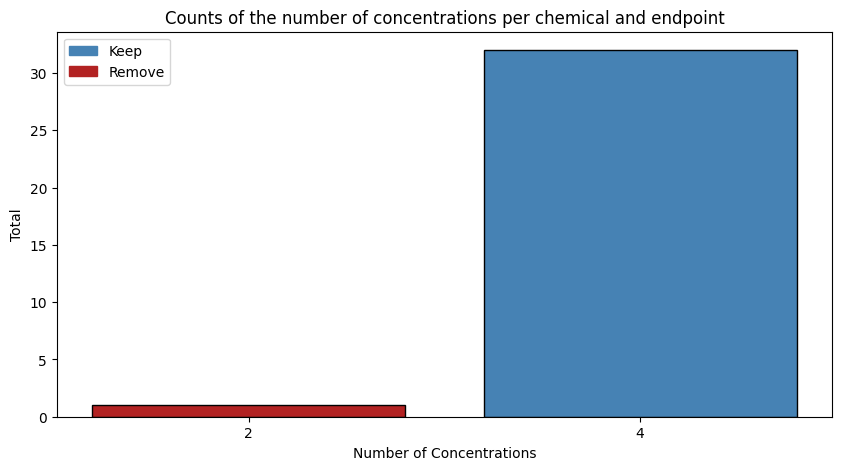

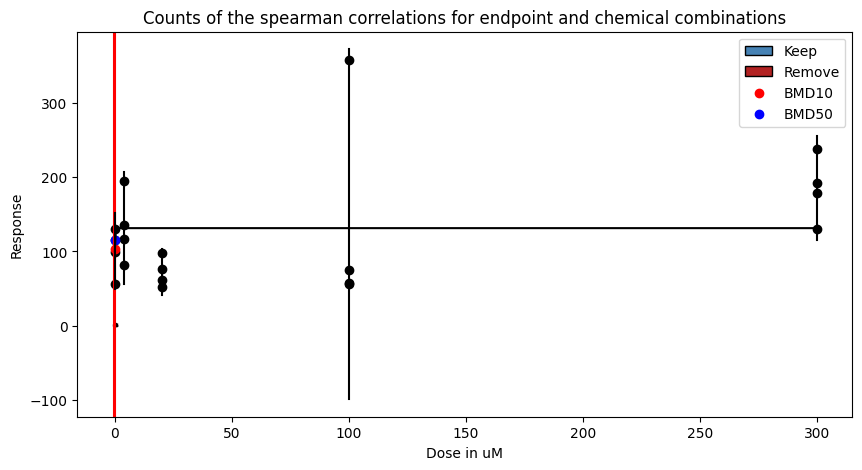

**Exponential Regression**
AIC: 10440.7858, BMDL: 299.8946
BMD10: 299.8946, BMD50: 299.3069


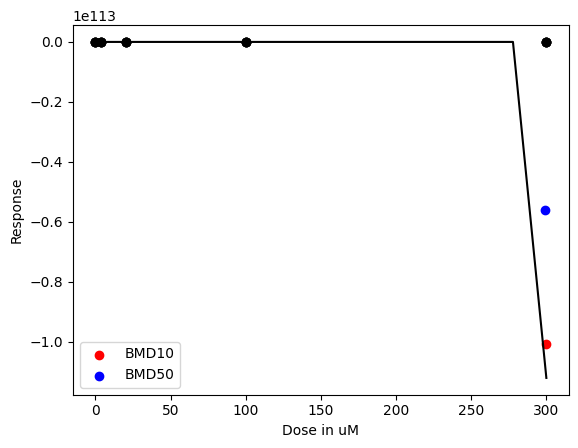

**Gompertz Regression**
AIC: 234.69, BMDL: nan
BMD10: 0.1018, BMD50: 0.1482


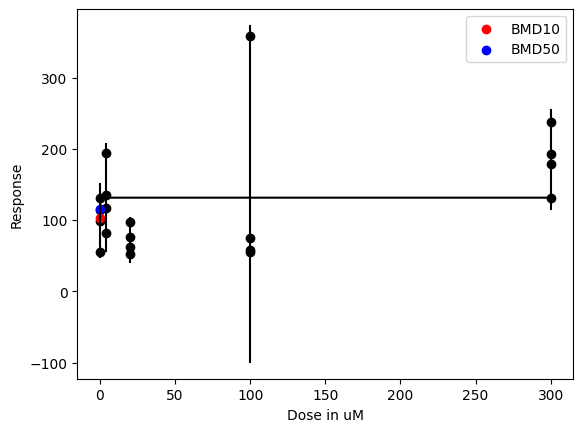

**Hill Regression**
AIC: 261.5483, BMDL: nan
BMD10: nan, BMD50: nan


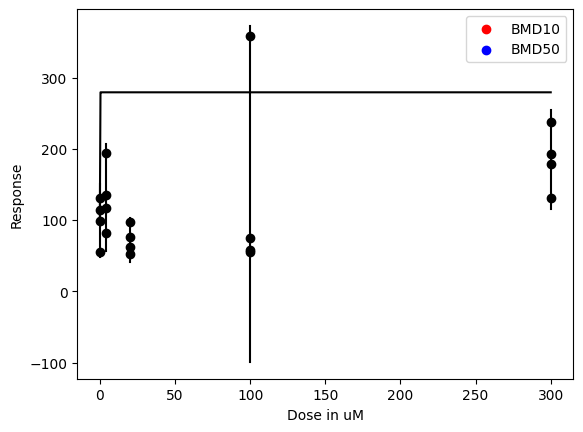

**Michaelis-Mentin Regression**
AIC: 227.2873, BMDL: nan
BMD10: 23.5647, BMD50: 130.2404


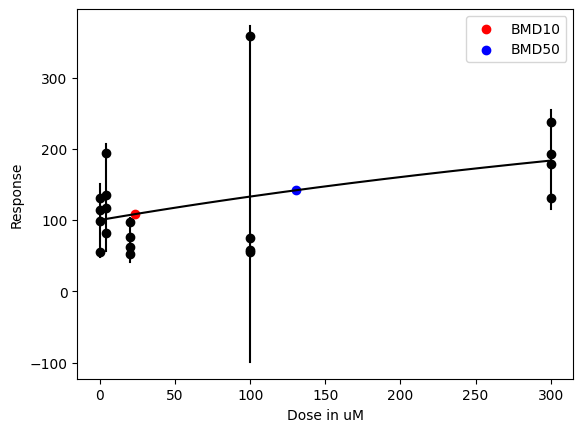

**Power Regression**
AIC: 229.2557, BMDL: 35.1969
BMD10: 35.725, BMD50: 158.0974


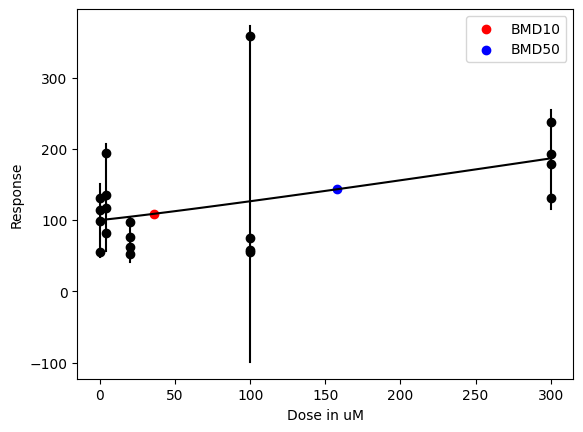

**Weibull Regression**
AIC: 234.69, BMDL: nan
BMD10: 0.3814, BMD50: 0.415


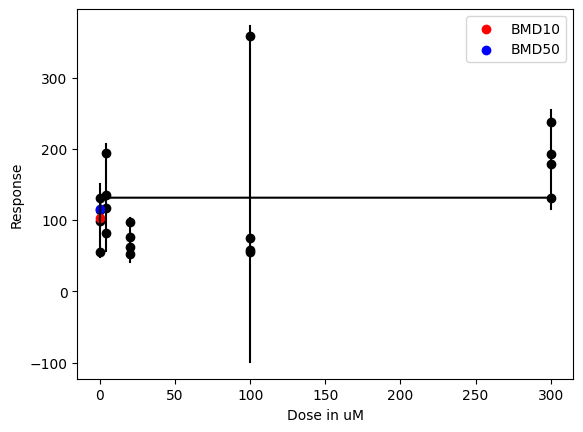

In [11]:
import numpy as np
from bmdrc.model_fitting_continuous import LinReg_Cont, AsyReg_Cont, ExpReg_Cont, GomReg_Cont, HillReg_Cont, MMReg_Cont, PowReg_Cont, WeiReg_Cont
import matplotlib.pyplot as plt

def quick_plot(obj, BMD10, BMD50):

    plt.ioff()
    plt.scatter(obj._toModel[obj._concentration], obj._toModel[obj._response], color = "black")
    plt.plot(obj.curve["Dose in uM"], obj.curve["Response"], color = "black")

    # Add confidence intervals
    for row in range(len(obj.CI)):
        plt.plot([obj.CI[obj._concentration][row], obj.CI[obj._concentration][row]], [obj.CI["Low"][row], obj.CI["High"][row]], color = "black")

    # Add BMD10 and BMD50
    plt.scatter(BMD10, obj.get_response_level(10), c = "red", label = "BMD10")
    plt.scatter(BMD50, obj.get_response_level(50), c = "blue", label = "BMD50")

    # Add labels and make plot
    plt.xlabel("Dose in uM")
    plt.ylabel("Response")
    plt.legend()

    plt.show()

def check_values(model_fun, degree = 1):

    # Define class
    if degree == 1:
        mod_def = model_fun(toModel = data, concentration = con._concentration, response = con._response)
    else:
        mod_def = model_fun(toModel = data, concentration = con._concentration, response = con._response, degree = degree)

    # Fit the linear model --> intercept is fixed at 100
    mod_def.fit(fixed_intercept = 100)
    mod_def.response_curve()
    mod_def.calc_conf_interv()

    print("AIC: " + str(np.round(mod_def.aic, 4)) + ", BMDL: " + str(np.round(mod_def.calc_bmdl(), 4)))
    BMD10 = mod_def.predict_x(mod_def.get_response_level(10))
    BMD50 = mod_def.predict_x(mod_def.get_response_level(50))
    print("BMD10: " + str(np.round(BMD10, 4)) + ", BMD50: " + str(np.round(BMD50, 4)))
    quick_plot(mod_def, BMD10, BMD50)

    return(mod_def)

plt.close()
print("**Asymptotic Regression**")
try:
    asy = check_values(AsyReg_Cont)
except:
    print("Asymptotic model did not converge\n\n")

print("**Exponential Regression**")
try:
    exp = check_values(ExpReg_Cont)
except:
    print("Exponential model did not converge\n\n")

print("**Gompertz Regression**")
try:
    gom = check_values(GomReg_Cont)
except:
    print("Gompertz model did not converge\n\n")

print("**Hill Regression**")
try:
    hill = check_values(HillReg_Cont)
except:
    print("Hill model did not converge\n\n")

print("**Michaelis-Mentin Regression**")
try:
    mm = check_values(MMReg_Cont)
except:
    print("Michaelis-Mentin model did not converge\n\n")

print("**Power Regression**")
try:
    pow = check_values(PowReg_Cont)
except:
    print("Power model did not converge\n\n")

print("**Weibull Regression**")
try:
    weib = check_values(WeiReg_Cont)
except:
    print("Weibull model did not converge\n\n")

In [12]:
con.fit_models(diagnostic_mode = True)

.....fitting models for 12 Endpoint1
.....fitting models for 6 Endpoint1
.....fitting models for 11 Endpoint1
.....fitting models for 13 Endpoint1
.....fitting models for 15 Endpoint1
.....fitting models for 4 Endpoint1
.....fitting models for 7 Endpoint1
.....fitting models for 8 Endpoint1
.....fitting models for 3 Endpoint1
.....fitting models for 12 Endpoint2
.....fitting models for 6 Endpoint2
.....fitting models for 11 Endpoint2
.....fitting models for 13 Endpoint2
.....fitting models for 15 Endpoint2
.....fitting models for 10 Endpoint2
.....fitting models for 14 Endpoint2
.....fitting models for 17 Endpoint3
.....fitting models for 16 Endpoint3
.....fitting models for 2 Endpoint3
.....fitting models for 9 Endpoint3
.....fitting models for 1 Endpoint3
.....fitting models for 12 Endpoint3
.....fitting models for 13 Endpoint3
.....fitting models for 16 Endpoint4
.....fitting models for 2 Endpoint4
.....fitting models for 5 Endpoint4
.....fitting models for 12 Endpoint4
.....fitting

In [13]:
# Find the best model per dataset
best_model = {item: "" for item in con.AIC_df["bmdrc.Endpoint.ID"].tolist()}

# Keep a list of possible model selections
poss_models = ["asymptotic", "exponential", "gompertz", "hill", "michaelis-mentin", "power", "weibull"]

# Find the best model
for row in range(len(con.AIC_df)):
    
    # Extract the endpoint
    endpoint = con.AIC_df["bmdrc.Endpoint.ID"][row]

    # Step 1: Extract the best models based on AIC
    values = np.array(con.AIC_df.iloc[row, 2:].to_list())
    min_value = np.min([val for val in values if not np.isnan(val)])
    model_choices = [poss_models[x] for x in range(len(values)) if not np.isnan(x) and (values[x] - min_value <= 2)] 
    if len(model_choices) == 1:
        best_model[endpoint] = model_choices[0]

    # Step 2: Select the smallest BMDL
    else:

        # Make a dictionary of BMDLs
        remaining = con.BMDLs_df[con.BMDLs_df["bmdrc.Endpoint.ID"] == endpoint][model_choices].reset_index(drop = True).loc[0].to_dict()

        # Select smallest BMDL if it is possible
        if not all(np.isnan(value) for value in remaining.values()):
            best_model[endpoint] = min(remaining, key = remaining.get)

        # Step 3: Otherwise, select smallest BMD10
        else:
            remaining = con.BMD10s_df[con.BMD10s_df["bmdrc.Endpoint.ID"] == endpoint][model_choices].reset_index(drop = True).loc[0].to_dict()
            best_model[endpoint] = min(remaining, key = remaining.get)

print(best_model)



{'12 Endpoint1': 'asymptotic', '6 Endpoint1': 'gompertz', '11 Endpoint1': 'power', '13 Endpoint1': 'asymptotic', '15 Endpoint1': 'power', '4 Endpoint1': 'power', '7 Endpoint1': 'power', '8 Endpoint1': 'power', '3 Endpoint1': 'power', '12 Endpoint2': 'gompertz', '6 Endpoint2': 'hill', '11 Endpoint2': 'weibull', '13 Endpoint2': 'power', '15 Endpoint2': 'hill', '10 Endpoint2': 'weibull', '14 Endpoint2': 'asymptotic', '17 Endpoint3': 'power', '16 Endpoint3': 'power', '2 Endpoint3': 'power', '9 Endpoint3': 'power', '1 Endpoint3': 'michaelis-mentin', '12 Endpoint3': 'power', '13 Endpoint3': 'power', '16 Endpoint4': 'hill', '2 Endpoint4': 'michaelis-mentin', '5 Endpoint4': 'gompertz', '12 Endpoint4': 'michaelis-mentin', '13 Endpoint4': 'asymptotic'}
